For this problem set you will implement a visual transformer and train it on MNIST.
The model you'll implement is based on the recent paper https://openreview.net/pdf?id=YicbFdNTTy, and
consists of a patch-wise linear projection of images followed by transformer layers that receive the
projected patches as a 1-dimensional sequence, akin to how transformers process text data.

Reading the paper is not necessary to complete the assignment, and the model you'll implement is a
minor simplification of the one proposed by the authors.

For reference, the model proposed in the paper is given below:

<img src="vit.png">

The main differences between the model above and the one you'll implement are:

1 - The sequence will not have an extra token in the beginning.

2 - The implemented model will not have patch / position embeddings at all.

3 - The classification head will take the whole sequence as input, instead of the first element only.

4 - Instead of extracting non-overlapping patches and linearly projecting them, you'll use a convolutional layer (the settings used for the conv layer makes these two equivalent, though).

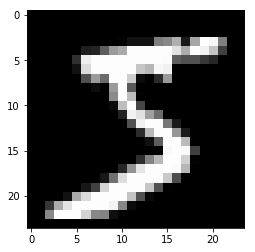

In [8]:
# We first load the MNIST data like in the previous assignment.
# For this homework the images will be cropped to 24x24 pixels, and will not be flattened into vectors.
# Each image is a tensor of size 1 x 24 x 24. A batch will be represented as a tensor of size B x 1 x 24 x 24.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

train_images = train_images[:,None,2:-2,2:-2]
test_images = test_images[:,None,2:-2,2:-2]

plt.imshow(train_images[0,0], cmap='gray', interpolation = 'nearest')
plt.show()

In [9]:
# These functions are used for training and are the same as the ones in the previous homework.

def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    total_loss = 0.0
    num_batches = num_samples//batch_size
    p = np.random.permutation(len(train_images))
    shuffled_train_images = train_images[p]
    shuffled_train_labels = train_labels[p]
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        xnode.value = shuffled_train_images[start:end]
        ynode.value = shuffled_train_labels[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(probnode.value, axis=1), ynode.value))
        if lossnode:
            total_loss += lossnode.value.mean()
            edf.Backward(lossnode)
            edf.SGD()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_err = run_epoch(batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(batch_size, test_images, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

In [10]:
# Here we have new EDF modules that will be helpful when implementing the transformer layers.
# Go over them to see how they're used and what they do, since you'll be using them later on.
# Note that Affine and Softmax were already given in the previous assignment, but differ from the ones
# presented below, so go over them as well.

class Affine(edf.CompNode):
    """
    Applies an affine transform to a CompNode x.
    
    This implementation differs from the one in the previous homework in two ways:
    1 - It creates the parameter matrix automatically, so no need to define a AffineParams beforehand.
    2 - The input x doesn't have to be a 2nd order tensor (matrix). If x is of higher order, it will be
    interpreted as a batch of matrices of dimensions given by the last two shapes.
    
    For example, if x has shape (64, 9, 10) and you set in_feats = 10, out_feats = 32, which defines a
    parameter matrix of size (10, 32), then the output will have shape (64, 9, 32) and will be computed by
    multiplying 64 many (9 x 10) matrices with the (10 x 32) parameter matrix, resulting in 64 many (9 x 32)
    matrices which are represented as a (64 x 9 x 32) tensor.
    
    In general, if x has shape (S_1, S_2, ..., S_{d-1}, S_d) and in_feats = S_d, out_feats = S_{d'}, then
    the output will have shape (S_1, S_2, ..., S_{d-1}, S_{d'}) and will be computed by performing
    a batched matmul over (S_1 * S_2 * ... * S_{d-2}) matrices of size (S_{d-1}, S_d) with the parameter matrix
    of size (S_d, S_{d'}). 
    """
    def __init__(self, x, in_feats, out_feats):
        edf.CompNodes.append(self)
        X = edf.Xavier(in_feats)
        self.w = edf.Parameter(np.random.uniform(-X,X,(in_feats,out_feats)))
        self.x = x

    def forward(self):
        self.value = self.x.value @ self.w.value

    def backward(self):
        self.x.addgrad(self.grad @ self.w.value.transpose())
        dw = (np.expand_dims(self.x.value, -1) * np.expand_dims(self.grad, -2)).reshape(-1, *self.w.value.shape)
        self.w.addgrad(dw)
        
class ReLU(edf.CompNode):
    """
    Applies the ReLU activation to a CompNode x, element-wise.
    """
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = np.maximum(0, self.x.value)

    def backward(self):
        self.x.addgrad(np.greater(self.x.value, 0) * self.grad)

class Sum(edf.CompNode):
    """
    Performs element-wise addition given two CompNodes x1 and x2.
    
    Note that x1 and x2 should have matching shapes. 
    """
    def __init__(self, x1, x2):
        edf.CompNodes.append(self)
        self.x1 = x1
        self.x2 = x2

    def forward(self):
        self.value = self.x1.value + self.x2.value
        
    def backward(self):
        self.x1.addgrad(self.grad)
        self.x2.addgrad(self.grad)
        
class Softmax(edf.CompNode):
    """
    Applies the softmax function over the last dimension of a CompNode s.
    
    This implementation will accept CompNodes of arbitrary order instead of only matrices.
    """
    def __init__(self, s):
        edf.CompNodes.append(self)
        self.s = s
        
    def forward(self):
        smax = np.max(self.s.value,axis=-1,keepdims=True)
        bounded = np.maximum(-10,self.s.value - smax)
        es = np.exp(bounded) 
        self.value = es / np.sum(es,axis=-1,keepdims=True)

    def backward(self):
        p_dot_pgrad = np.matmul(np.expand_dims(self.value, -2), np.expand_dims(self.grad, -1)).squeeze(-1)
        self.s.addgrad(self.value * (self.grad - p_dot_pgrad))

class Reshape(edf.CompNode):
    """
    Reshapes a tensor given the desired output shape.
    
    Takes as input a CompNode and the desired size, which should be a tuple of ints (excluding batch size!).
    For example, if x has shape (64, 1, 24, 24) and size = (576,), then the output will have a shape
    of (64, 576). You'll get an error if the shapes have a different number of elements.
    """
    def __init__(self, x, size):
        edf.CompNodes.append(self)
        self.x = x
        self.size = size

    def forward(self):
        self.value = self.x.value.reshape(self.x.value.shape[0], *self.size)
        
    def backward(self):
        self.x.addgrad(self.grad.reshape(self.x.value.shape))

class Transpose(edf.CompNode):
    """
    Transposes a tensor given two dimensions.
    
    Takes as input a CompNode x and two dimensions dim1, dim2, which should be ints, and permutes the
    dimensions dim1, dim2 of x.
    
    For example, if x has shape (64, 32, 9) and dim1 = 1, dim2 = 2, then the output will have a shape
    of (64, 9, 32), and will be given by output[i,j,k] = x[i,k,j].
    """
    def __init__(self, x, dim1, dim2):
        edf.CompNodes.append(self)
        self.x = x
        self.dim1, self.dim2 = dim1, dim2

    def forward(self):
        self.value = self.x.value.swapaxes(self.dim1, self.dim2)
        
    def backward(self):
        self.x.addgrad(self.grad.swapaxes(self.dim1, self.dim2))
        
class BatchedMatmul(edf.CompNode):
    """
    Performs a batched matrix multiplication between two CompNodes x1, x2 of order at most 3.
    
    Given CompNodex x1, x2 with shapes (S_1, S_2, S_3), (S_1, S_3, S_4), this will compute
    S_1 independent matmuls between matrices of shape (S_2, S_3) and (S_3, S_4), each one resulting
    in a matrix of shape (S_2, S_4), resulting in an output tensor of shape (S_1, S_2, S_4).
    """
    def __init__(self, x1, x2):
        edf.CompNodes.append(self)
        self.x1 = x1
        self.x2 = x2

    def forward(self):
        self.value = self.x1.value @ self.x2.value
        
    def backward(self):
        self.x1.addgrad(self.grad @ self.x2.value.swapaxes(-1,-2))
        self.x2.addgrad(self.x1.value.swapaxes(-1,-2) @ self.grad)
        


In the next cell you'll have to implement a convolutional layer as an EDF CompNode, including its forward and backward passes.

Note that the filter tensor has shape (C_out, C_in, k, k), where C_in is the number of channels that the input has, C_out is how many channels the output will have, and k is the kernel size (we will be considering only square kernels for simplicity).

The input is assumed to have shape (B, C_in, S, S), where B is the batch size and S is the spatial resolution -- we'll also be assuming inputs are square images for simplicity.

Note that your implementation should also account for padding and stride, which are explained in the course slides.

In [11]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    out_height = (H + 2 * padding - field_height) // stride + 1
    out_width = (W + 2 * padding - field_width) // stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                                                             stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                                     stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                                                             stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [12]:
class Conv(edf.CompNode):
    """
    Applies a convolution to a CompNode x, and takes as parameters in_channels, out_channels, k, padding,
    and stride, which should all be ints (k is the kernel size).
    
    This CompNode will automatically create a EDF Parameter with shape (out_channels, in_channels, k, k)
    which will represent the filter bank of the conv layer (ie out_channels many 
    filters of size in_channels x k x k).
    """
    def __init__(self, x, in_channels, out_channels, k, padding, stride):
        edf.CompNodes.append(self)
        self.in_channels, self.out_channels, self.k, self.padding, self.stride = in_channels, out_channels, k, padding, stride
        gain = edf.Xavier(self.in_channels * self.k**2)
        self.w = edf.Parameter(np.random.uniform(-gain,gain,(out_channels, in_channels, k, k)))
        self.x = x

    def forward(self):
        # implementation goes here
        batch, c_in, height, width = self.x.value.shape
        out_height = (height - self.k + 2 * self.padding) // self.stride + 1
        out_width = (width - self.k + 2 * self.padding) // self.stride + 1

        self.x_col = im2col_indices(self.x.value, self.k, self.k, 
                               padding=self.padding, stride=self.stride)
        w_col = self.w.value.reshape(self.out_channels, -1)

        val = w_col @ self.x_col
        val = val.reshape(self.out_channels, out_height, out_width, batch)
        self.value = val.transpose(3, 0, 1, 2)
        
    def backward(self):
        # implementation goes here
        grad_reshaped = self.grad.transpose(1, 2, 3, 0).reshape(self.out_channels, -1)
        dw = grad_reshaped @ self.x_col.T
        dw = dw.reshape(self.w.value.shape)
        self.w.addgrad(dw)

        w_reshaped = self.w.value.reshape(self.out_channels, -1)
        dx_col = w_reshaped.T @ grad_reshaped
        dx = col2im_indices(dx_col, self.x.value.shape, self.k, self.k, 
                            padding=self.padding, stride=self.stride)
        dx = dx.reshape(self.x.value.shape)
        self.x.addgrad(dx)

In [ ]:
# debug forward
edf.clear_compgraph()
xnode = edf.Input()

out = Conv(xnode, 1, 1, 3, 1, 1)

out.w.value *= 0
out.w.value[0,0,1,1] = 1

xnode.value = train_images[:2]
edf.Forward()

plt.imshow(train_images[0,0], cmap='gray', interpolation = 'nearest')
plt.show()
plt.imshow(out.value[0,0], cmap='gray', interpolation = 'nearest')
plt.show()

print(((train_images[0,0] - out.value[0,0])**2).sum())

In [ ]:
# debug backward
class L2Loss(edf.CompNode):
    def __init__(self, x, t):
        edf.CompNodes.append(self)
        self.x = x
        self.t = t
    def forward(self):
        self.value = (0.5 * (self.x.value - self.t.value)**2).mean((1,2,3))
    def backward(self):
        self.x.addgrad(self.grad * (self.x.value - self.t.value) / np.prod(self.x.value.shape[1:]))

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
out = Conv(xnode, 1, 1, 3, 1, 1)
lossnode = L2Loss(out, ynode)
edf.learning_rate = 1.0
xnode.value = train_images[:1]
ynode.value = train_images[:1]

for i in range(100):
    edf.Forward()
    edf.Backward(lossnode)
    edf.SGD()
    print(lossnode.value)
    print(out.w.value)
plt.imshow(out.value[0,0], cmap='gray', interpolation = 'nearest')
plt.show()

We will train a small CNN to test your implementation. The cell below will define and train a CNN with 4 conv layers on MNIST, the first three layers having a kernel size of 3, padding of 1 and stride of 2 -- these settings should result in each layer halving the spatial resolution of its input, so the spatial resolution of the first three conv layer outputs should be 12x12, 6x6, and 3x3, respectively. The last layer has a kernel size of 3x3 and no padding, hence its output should have a spatial resolution of 1x1 (and 10 channels). The reshape layer will transform the (B x 10 x 1 x 1) tensor into a (B x 10) one, which will be interpreted as the scores for class probabilities.

In [ ]:
np.random.seed(1234)
batch_size = 64
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

def CNN(x, y):
    u = ReLU(Conv(x, 1, 4, 3, 1, 2))
    u = ReLU(Conv(u, 4, 8, 3, 1, 2))
    u = ReLU(Conv(u, 8, 16, 3, 1, 2))
    u = Conv(u, 16, 10, 3, 0, 1)
    u = Reshape(u, (10,))
    probnode = edf.Softmax(u)
    lossnode = edf.LogLoss(probnode, y)
    return probnode, lossnode

probnode, lossnode = CNN(xnode, ynode)

num_epochs = 5
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
print('\nloss', lossnode.value)

If implemented correctly, the model above should be able to achieve less than 3% train/test error.

You'll also want the implementation to be somewhat optimized such that the above cell doesn't take more than ~10 minutes to run. To do that, you should have no more than 2 nested loops and all remaining dimension-wise operations should be properly vectorized via numpy calls.

Ideally your implementation should have no Python loops at all and rely purely on numpy calls and smart vectorization. As a hint to achieve that, note that when convolving a C x k x k kernel over a C x S x S image, each element in the output tensor will be given by a inner product between the kernel and a C x k x k slice of the input image, therefore if the output has shape S' x S', then it can be computed directly by a inner product between a S' x S' x C x k x k tensor (which stores S'^2 many input slices of shape C x k x k) and the C x k x k filter. Note that this holds for each filter of the conv layer independently, so you'll need to account for an extra dimension when computing the output of all filters at the same time.

In [ ]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Now, you have to implement a LayerNorm and a SelfAttention layer in EDF.

For LayerNorm, you don't need to implement the learnable affine transform that follows normalization, so the layer shouldn't have parameters at all. We will only apply it on input tensors of 3rd order, so your implementation doesn't have to work for arbitrarily-sized input tensors.

Note that SelfAttention below is --not-- a CompNode class. It turns out that SelfAttention can be implemented by simply stacking layers that have already been defined, so you don't have to worry about implementing a forward and backward pass for it. However, if you can't figure out how to implement it by stacking the given components, you can implement a CompNode instead as long as your forward and backward passes are correct.

Also note that you only need to implement single-head attention. This should be considerably easier than multi-head since input, intermediate, and output tensors will be always of 3rd order instead of 4th, hence some layers defined above can be used (but wouldn't if you were to implement multi-head attention).

In [ ]:
class LayerNorm(edf.CompNode):
    """
    Applies Layer Normalization to an input tensor of 3rd order.
    
    More specifically, given an input tensor of size (S_1, S_2, S_3), Layer Norm computes the mean and
    deviation of each of the S_1 many matrices of shape (S_2, S_3) and normalizes each matrix element using
    the correspondent mean and std.
    """
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here
        _, S_2, S_3 = self.x.value.shape
        self.normalizer = S_2 * S_3
        mu = np.mean(self.x.value, axis=(1, 2)) # sum over S_2, S_3
        self.mu = np.expand_dims(mu, axis=(-1, -2))
        self.residuals = self.x.value - self.mu
        sum_residuals = np.sum(self.residuals, axis=(1, 2), keepdims=True)
        self.variance = np.multiply(sum_residuals, sum_residuals) / self.normalizer
        self.std = np.sqrt(self.variance)
        self.value =  self.residuals / self.std
        
    def backward(self):
        # implementation goes here
        d_mu = np.zeros(self.mu.shape)
        d_variance = np.zeros(self.variance.shape)
        
        temp = self.grad * np.reciprocal(self.std)
        self.x.addgrad(temp)
        d_mu -= np.sum(temp, axis=(1, 2), keepdims=True)
        d_variance -= np.sum(self.grad * self.residuals,
                             axis=(1, 2), keepdims=True) * \
        np.reciprocal(self.variance * self.std) / 2
        
        temp = 2 * d_variance * self.residuals / self.normalizer
        self.x.addgrad(temp)
        d_mu -= np.sum(temp, axis=(1, 2), keepdims=True)
        
        self.x.addgrad(d_mu / self.normalizer)
        
def SelfAttention(x, in_dim, att_dim):
    """
    Applies single-head Self Attention to a input CompNode x. in_dim should be the number of 
    features of x (a int), and att_dim is the dimension of the query, key, and value tensors.
    
    The input x is assumed to be a 3rd order tensor with size (B, T, in_dim), where B is the batch size,
    T is the sequence length, and in_dim is the number of features. The layer produces query, key, and value
    tensors, each of shape (B, T, att_dim) via a linear transformation acting on x.
    
    Afterwards, the attention tensor of shape (B, T, T) is computed from q and k, as described in the 
    course material. Normalizing the input of the softmax function by sqrt(att_dim) is optional.
    Then, an intermediate tensor h is produced from the attention and value tensors, having 
    shape (B, T, att_dim). Finally, the output of shape (B, T, in_dim) is generated by applying a 
    linear transformation on h.
    """
    q = Affine(x, in_dim, att_dim)
    k = Affine(x, in_dim, att_dim)
    v = Affine(x, in_dim, att_dim)
    att = Softmax(BatchedMatmul(q, Transpose(k, 1, 2)))
    h = BatchedMatmul(att, v)
    out = Affine(h, att_dim, in_dim)
    
    return out

Lastly, you'll implement a TransformerLayer, which is composed of a residual block with a LayerNorm -> SelfAttention trunk, followed by another residual block with a LayerNorm -> Affine -> ReLU -> Affine trunk, where the first Affine layer doubles the number of features and the second halves it, such that the output has the same shape as the input.

More specifically, the layer should be:

u = SelfAttention(LayerNorm(x)) + x

out = Affine(ReLU(Affine(LayerNorm(x)))) + u

Remember that addition in the residual blocks needs to be backprop'able!

In [ ]:
def TransformerLayer(x, in_dim, att_dim):
    # implementation goes here
    u = Sum(SelfAttention(LayerNorm(x), in_dim, att_dim), x)
    out = Sum(Affine(ReLU(Affine(
        LayerNorm(x), in_dim, att_dim)), in_dim, att_dim), x)
    return out

The cell below will train a Visual Transformer with two Transformer layers. If your implementation is correct, then it should be able to achieve around 2% train/test error.

In [ ]:
np.random.seed(1234)
batch_size = 64
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

dim = 32
patch_size = 8
seq_len = (24 // patch_size)**2

u = Conv(xnode, 1, dim, patch_size, 0, patch_size)
u = Reshape(u, (dim, seq_len))
u = Transpose(u, 1, 2)

u = TransformerLayer(u, dim, dim)
u = TransformerLayer(u, dim, dim)

u = Reshape(u, (seq_len*dim,))
scores = Affine(u, seq_len*dim, 10)

probnode = edf.Softmax(scores)
lossnode = edf.LogLoss(probnode, ynode)

num_epochs = 10
edf.learning_rate = 0.05
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)